<div align=center>
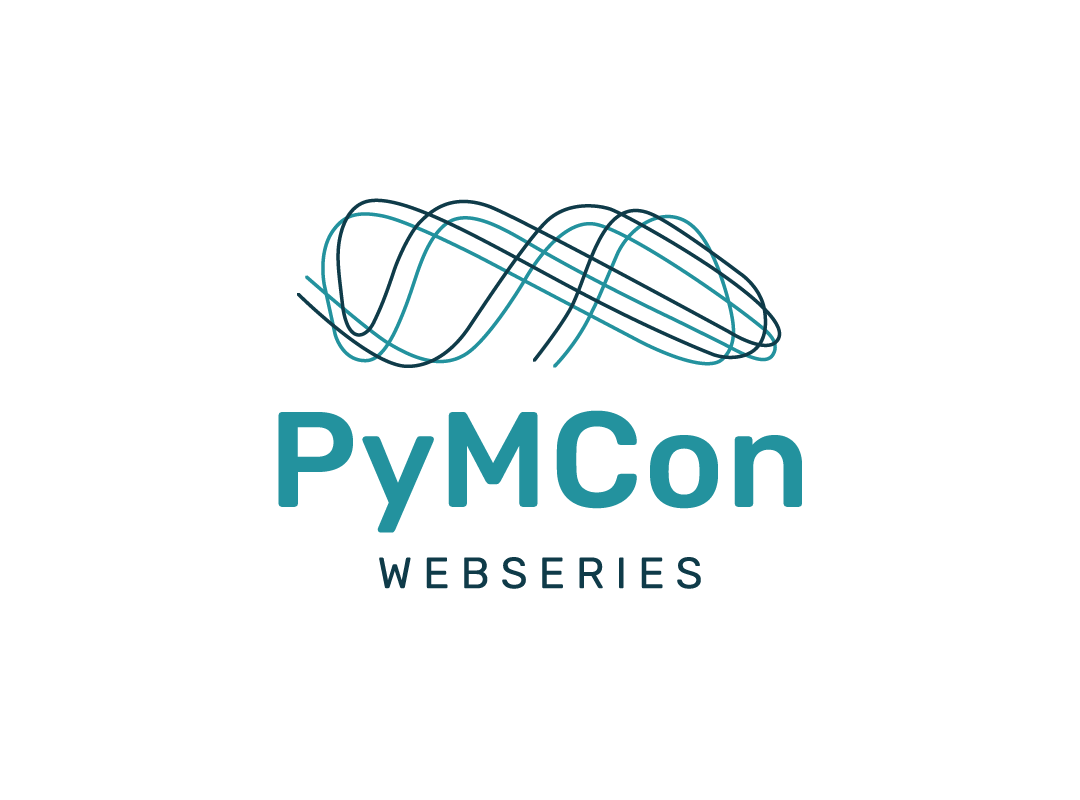
</div>

# The Power of Bayes in Industry: A Primer on Data Generating Processes

In a couple of weeks, the 2023 PyMCon Web Series will be kicking off with the talk [The Power of Bayes in Industry](https://pymcon.com/events/), which will discuss the advantages of bringing a _first principles_ approach to modeling industry problems, powered by a strong understanding of the _data generating process_.

This notebook serves as a companion to the upcoming talk, taking a deep dive into the technical concepts behind the talk's thesis, namely

- What is a _data generating process_?
- What do we mean by a _first principles model_?
- How does one _express these concepts in code_ with tools like `scipy` and `pymc`?

We'll do this by walking through the well-known [golfing case study](https://mc-stan.org/users/documentation/case-studies/golf.html) popularized by Andrew Gelman. Along the way we'll add additional commentary and attempt to explain the some of the choices and derivations used to specify the full model. You can also reference [this example](https://www.pymc.io/projects/examples/en/latest/case_studies/putting_workflow.html) from the [PyMC example gallery](https://www.pymc.io/projects/examples/en/latest/gallery.html) for additional context.

Let's begin.

# What is a _data generating process_ anyway?

The term _data generating process_ (DGP) can be a bit overloaded, sometimes taking on slightly different meanings. For the purpose of our discussion here there are two meanings of interest.

The first is what is sometimes called the _true data generating process_. This is the set of real-world phenomena that generates some data. This could be as simple as rolling a die or shuffling a deck of cards. It could also be as complex as, well, any physical process or system you can imagine.

Because a complete understanding of the _true data generating process_ often eludes us, we resort to working with _approximations_ or _models_ of the _true DGP_. These are also sometimes referred to as a _DGP_ when a generative model is used.

This brings us to our next point.

# What is a _first principles_ approach?

What do we mean by a _first principles_ approach? Informally, we could say that a first principles approach is one that _emphasizes modeling the DGP_ rather than simply modeling outcomes or observed data. Consider the following ways in which we could write a model

<br>
<div align="center">
<table style="background-color: #FFFFFF text-align: center">
    <th>Top Down</th>
    <th>Bottom Up</th>
    <tr>
        <td>
            \begin{align}
            y\vert\theta_{1},\theta_{2}&\sim D(\theta_{1}, \theta_{2}) \\
            \theta_{1}\vert\alpha&\sim D_{1}(\alpha) \\
            \theta_{2}\vert\alpha&\sim D_{2}(\alpha) \\
            \end{align}
        </td>
        <td>
            \begin{align}
                    \theta_{1}\vert\alpha\sim D_{1}(\alpha)\quad &\quad \theta_{2}\vert\alpha\sim D_{2}(\alpha)\\
                       \searrow\quad&\swarrow \\
                       y\vert\theta_{1},\theta_{2}\sim& D(\theta_{1},\theta_{2})
            \end{align}
        </td>
    </tr>
</table>
</div>
<br>

While the "Top Down" notation calls immediate attention to the model outputs, the "Bottom Up" notation begins with the priors, or assumptions, working it's way up into the outputs, tracing how each component of the model fits together.

Neither method is "right" or "wrong". Neither does one convey more information than the other.  Each has pros and cons and is more suitable in some contexts than others. It's _the way that information is represented_ that prompts us to raise this contrast.

Our point is that the "Bottom Up" way of thinking complements a first principles approach well, particularly when the structure of the model maps concretely onto our understanding of the DGP. We'll refer back to this notation later on.

Admittedly, this is all rather vague though. In my opinion, examples make this point much more clearly than words alone and I can think of no better example to illustrate this concept than the [putting case study](https://mc-stan.org/users/documentation/case-studies/golf.html), popularized by Andrew Gelman and the Stan team.

## Let's golf

If you're unfamiliar with this case study, the data set contains 19 observations, each with three features

- $x:=$ The distance of the put
- $n:=$ The number of puts observed from the distance $x$
- $y:=$ The number of successful puts from $x$

Here are the first few rows of the data set

In [ ]:
#@title
import io

import matplotlib.pyplot as plt
import pandas as pd


df = pd.read_csv(
    io.StringIO('x n y\n2 1443 1346\n3 694 577\n4 455 337\n5 353 208\n6 272 149\n7 256 136\n8 240 111\n9 217 69\n10 200 67\n11 237 75\n12 202 52\n13 192 46\n14 174 54\n15 167 28\n16 201 27\n17 195 31\n18 191 33\n19 147 20\n20 152 24'),
    sep=' ')
df.head()

,x,n,y
0,2,1443,1346
1,3,694,577
2,4,455,337
3,5,353,208
4,6,272,149


Unsurprisingly, a plot of the percentage of successful puts by distance reveals that one is less likely to make a put the further they are from the hole.

(0.0, 1.0)

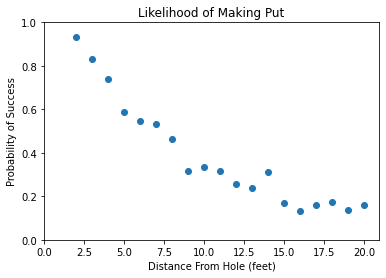

In [ ]:
#@title

fig, ax = plt.subplots()

df['p'] = df.y / df.n
ax.scatter(df.x, df.p)
ax.set_title('Likelihood of Making Put')
ax.set_xlabel('Distance From Hole (feet)')
ax.set_ylabel('Probability of Success')
ax.set_xlim([0, None])
ax.set_ylim([0, 1])

## First principles

The first principles model is quite simple, but, like the solution to all interesting problems, not necessarily obvious. Rather than attempt an exercise in curve fitting, Gelman et al. take a step back and consider the true data generating process. They proceed by assuming that the following statements closely approximate the true DGP.

- Golfers attempt to hit the ball completely straight
- Shots do not systematically list to the left or the right
- Shots of 0 distance must go in
- Probability of success must go to 0 as distance increases

Altogether, this point of view suggests a geometric model, in which the success of a put is determined by whether the angle of that shot is within the degree of tolerance required by the distance of the put, $x$.

<div align=center>
      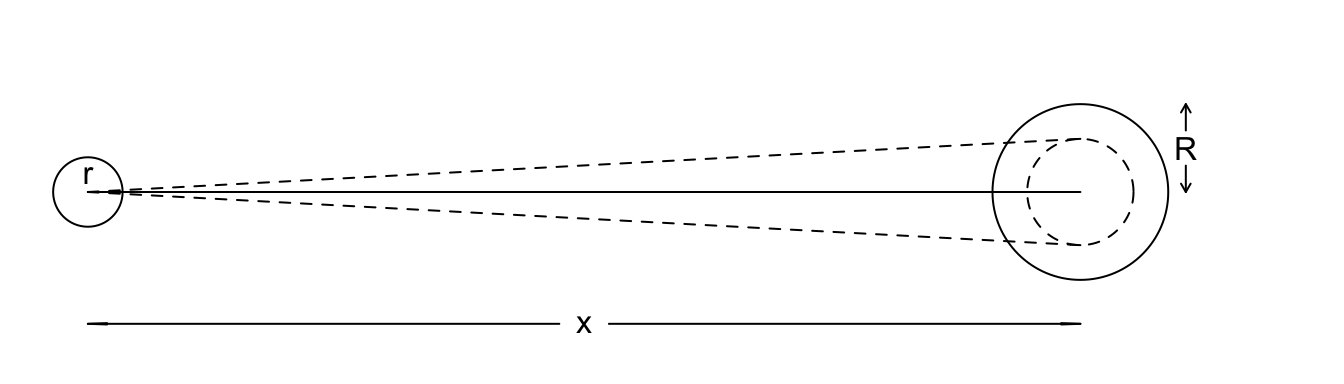
<p>
      Image Source: <a href="https://mc-stan.org/users/documentation/case-studies/golf.html">Stan Development Team</a>
</p>
</div>

> ⓘ **Note**
>
> For those trying to follow along with the Stan case study, which begins with an "off-the-shelf" method (i.e. logistic regression) before progressing to the first principles model, we intend to work in the opposite direction. We think this serves the purpose of our investigation here by emphasizing the advantages of starting with a strong mental model.

## Prior predictive samples

With a model of the data, _or should we say a model of the DGP_, in hand, we can simulate outcomes from the model. A bit of trigonometry shows that any shot with an angle $\alpha:\vert\alpha\vert<\theta_{max}$ will be successful, where

$$
\theta_{max}=\text{sin}^{-1}\left(\frac{R - r}{x}\right)
$$

According to our assumptions we can simulate the angle of various puts, $\tilde{\alpha}$, from draws of the distribution $\text{Normal}(0, \sigma)$. These can be compared to $\theta_{max}$ to determine whether the simulated put was a success. Finally, we can compute the average rates of successful puts by distance and compare to the observed data.

This method of sampling from our prior and comparing to observed outcomes is known as _prior predictive sampling_. This technique is an incredibly useful tool for checking the validity of a model's assumptions _before_ model fit. That is, this can all be done _a priori_ without any inputs from the data set, with the exception of the final step which compares to the observed data.

### Generating the samples

To illustrate the intuitive nature of selecting priors with a first principles model, fill in the form with your best guess of $\sigma$ before running the cells below. Remember the data represents professional golfers and our model assumes

$$
\text{angle of put}=\alpha\sim N(0,\sigma)
$$

Thus $\sigma=3$ implies about 68% of professional puts err within $\pm3^{o}$ from the ideal put $\alpha=0^{o}$.

You may want to copy the sketch of the geometric model above onto paper and trace out different trajectories to build some intuition for what a reasonable value (or range of values) might be. It may take a few attempts to narrow in on values that fit the data, but you'll learn something about your own set of assumptions along the way.

Of course, you can always just _plug-and-chug_ or _guess-and-check_, but following the exercise above will help illustrate how a strong mental model can greatly simplify the process of choosing priors.

In [ ]:
#@markdown ##Input
#@markdown Run this and the hidden cell below to see
#@markdown the simulated outcomes of put success given 𝜎.
𝜎 = None #@param {type:"number"}


import numpy as np
import scipy.stats as ss


# defining constants and inputs to the simulation
N = 30
r = golf_ball_radius = 1.68 / 2  # inches
R = hole_radius = 4.25 / 2       # inches
X = df.x.values * 12             # inches

def simulate_put_success(x, 𝜎, n):
    # sampling from the prior
    shot_angle = ss.norm(0, 𝜎).rvs(N)

    # need to convert from rads to degrees
    θ_max = np.arcsin((R - r) / X) / np.pi * 180

    # using vectorization / broadcasting to simulate the outcomes
    return np.mean(
        np.abs(shot_angle[None, :]) <= θ_max[:, None],
        axis=1)

simulated_outcomes = simulate_put_success(X, 𝜎, N)


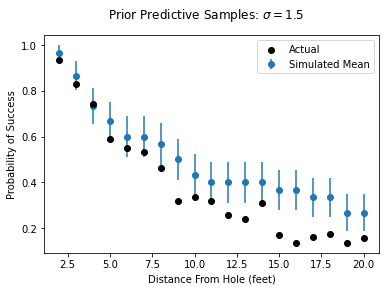

In [ ]:
#@title
# plot the simulated outcomes

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.suptitle(f'Prior Predictive Samples: $\sigma={𝜎:.1f}$')
ax.errorbar(
    df.x,
    simulated_outcomes,
    yerr=np.sqrt(simulated_outcomes * (1 - simulated_outcomes) / N),
    color='C0',
    label='Simulated Mean',
    ls='',
    marker='o')
ax.scatter(df.x, df.p, color='k', zorder=10, label='Actual')
ax.set_ylabel('Probability of Success')
ax.set_xlabel('Distance From Hole (feet)')
_ = ax.legend()

> ⓘ **Note**
>
> `pymc` has built-in methods for [prior predictive sampling](https://www.pymc.io/projects/docs/en/stable/api/generated/pymc.sample_prior_predictive.html), which are extremely useful and demonstrated below.
>
> However, I find it helpful when first working through a model to work out the prior predictive samples with `scipy.stats` or `numpy.random` for the following reasons
> 
> - It requires you to keep early iterations fairly simple since increasing the complexity of the model quickly becomes cumbersome to implement.
> - Similarly, it can help prevent us from getting ahead of ourselves and jumping to fit a model too quickly since the likelihood is (usually) not easily accessible.
> - By removing some of the magic of `pymc` we have to be a bit more "hands-on" with our implementation. This can help us learn subtleties about our model or probability in general.

> ⓘ **Note**
>
> For the purpose of illustration this is an intentionally naive way of generating prior predictive samples. Technically the plot above treats our prior as a constant, i.e. $\sigma=c$.
>
> In a more representative use case a prior distribution would be assigned to $\sigma$. We would then sample from that distribution to generate values $\tilde{\sigma}$, generating the samples $\tilde{\alpha}\sim N(0,\tilde{\sigma})$ in turn.
>
> This would be like rerunning the cell above for many different values of $\sigma$ and collecting the results of each execution. We'll follow this process below, but for this section thought it best to keep things simple.

## Deriving the likelihood

We now have a pretty good conceptual foundation of the DGP and have verified empirically that it can reasonably approximate the observed data from prior predictive samples. There are still a few key pieces we need to fill in though.

When I was first introduced to this example, I was able to follow the intuition up to this point, but had no idea of where to go from here, or how to turn the first principles model into something you could fit. It just didn't fit with any of the methods I was familiar with at the time (e.g. algorithms built on linear algebra or decision trees, à la `sklearn.fit()`). If this sentiment resonates with you, this section will try to bridge that gap.

### Tying it all together

To help connect the dots, let's take stock of what we have so far in terms of Bayes Theorem

$$
P(H\vert D)\propto P(D\vert H)\ P(H)
$$

The model's priors $P(H)$ are accounted for; in our case we only have one variable we need to assign a distribution to: $\sigma$. A Gamma distribution with mean 3 and standard deviation 1.5 should do.

What's lacking, then, is the quantity $P(D \vert H)$, that is, the likelihood of an observation for a given value of $\sigma$.

Let's start by identifying a likelihood function that fits our problem and then see what we need to get there.

Because our outcomes are measured as counts, ($n$, $y$), a [Binomial](https://en.wikipedia.org/wiki/Binomial_distribution) likelihood seems a reasonable choice. That is

$$
P(y\vert\sigma)=L_{Binom}(y\vert n, p, \sigma)
$$

Since ($n$, $y$) are given to us we just need to figure out how to obtain $p$, that is the probability a put is successful given our prior $\sigma$ and an input $x$. In the spirit of the "bottom-up" notation mentioned above, we can simply follow our assumptions forward until we reach $p$.

Revisiting our conceptual model, we see that this is just

$$
p=P(\vert\alpha\vert < \theta_{max}\vert\sigma,x)
$$

which is easily obtained by exploiting the symmetry of the normal CDF (recall $\alpha\sim N(0, \sigma)$)

$$
p=1-2 \text{F}_{\sigma}\left(\frac{-\theta_{max}}{x}\right)
$$

We now have everything needed to build a model we can fit to the data.

### Throwbacks

Before moving on, let's consider two points.

First, this final calculation, the _analytic probability of put success_, corresponds to the simulated means we examined from the prior predictive samples above. This is illustrated in the chart below.

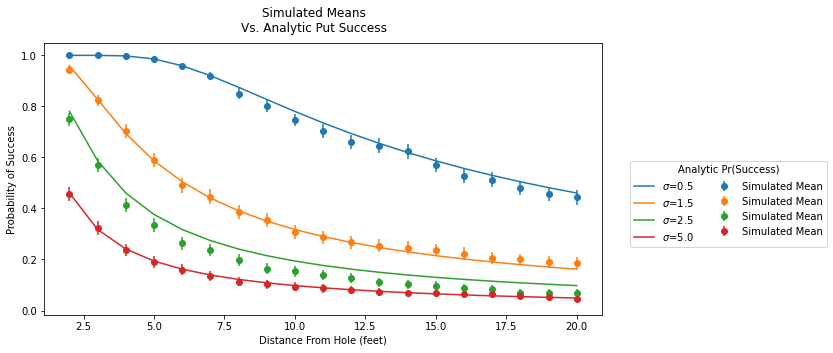

In [ ]:
#@title
sigma_vals = ".5,1.5,2.5, 5"
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Simulated Means\nVs. Analytic Put Success')

# defining constants and inputs to the simulation
N = 300
F = ss.norm.cdf
r = golf_ball_radius = 1.68 / 2  # inches
R = hole_radius = 4.25 / 2       # inches
X = df.x.values * 12             # inches

for i, 𝜎 in enumerate(sigma_vals.split(',')):
    𝜎 = float(𝜎)
  
    # need to convert from rads to degrees
    θ_max = np.arcsin((R - r) / X) / np.pi * 180
    p = 1 - 2 * F(-θ_max / 𝜎)

    # simulated values for comparison
    simulated_outcomes = simulate_put_success(X, 𝜎, N)

    ## everything below is plotting

    ax.plot(df.x, p, color=f'C{i}', label=f'$\sigma$={𝜎:.1f}')
    ax.errorbar(
        df.x,
        simulated_outcomes,
        yerr=np.sqrt(simulated_outcomes * (1 - simulated_outcomes) / N),
        color=f'C{i}',
        label='Simulated Mean',
        ls='',
        marker='o')

ax.set_ylabel('Probability of Success')
ax.set_xlabel('Distance From Hole (feet)')
_ = ax.legend(title='Analytic Pr(Success)', loc=(1.05, .25), ncol=2)

Second, we can now revisit prior predictive sampling, this time running them all the way through to $p$. Observe that it is no longer necessary to generate sample trajectories $\tilde{\alpha}$ nor take a mean as our calculation of $p$ integrates over this parameter.

In [ ]:
#@markdown ##Input
#@markdown Run this and the hidden cell below to see the calculation
#@markdown of $p=\text{P}(\text{Put Success}\vert\sigma,x)$.

#@markdown Enter multiple values of $\sigma$ using a comma separated list.
#@markdown

𝜎_vals = ".5, 1.5, 2.5, 5" #@param {type:"string"}


import numpy as np
import scipy.stats as ss

# defining constants and inputs to the simulation
F = ss.norm.cdf
r = golf_ball_radius = 1.68 / 2  # inches
R = hole_radius = 4.25 / 2       # inches
X = df.x * 12                    # inches

p_vals = {}  
for 𝜎 in 𝜎_vals.split(','):
    𝜎 = float(𝜎.strip())
    # need to convert from rads to degrees
    θ_max = np.arcsin((R - r) / X) / np.pi * 180
    p = 2 * F(θ_max / 𝜎) - 1

    # bookkeeping to generate the plot below
    p_vals[𝜎] = p

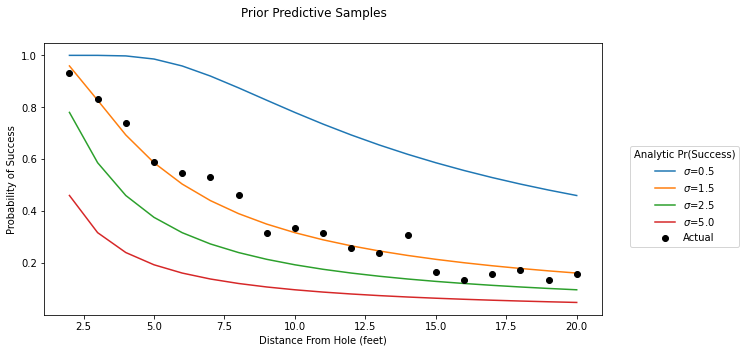

In [ ]:
#@title
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Prior Predictive Samples')

for 𝜎, p in p_vals.items():
    ax.plot(df.x, p, label=f'$\sigma$={𝜎:.1f}')

ax.scatter(df.x, df.p, color='k', zorder=10, label='Actual')
ax.set_ylabel('Probability of Success')
ax.set_xlabel('Distance From Hole (feet)')
_ = ax.legend(title='Analytic Pr(Success)', loc=(1.05, .25))

We built the following interactive chart to really tie together the geometric model, $p$, and the prior $\alpha\sim N(0,\sigma)$. They key idea is how our assumptions map onto a concrete probability distribution.

ⓘ **Note**: You will need to run the code to enable the interactions.

In [ ]:
#@title
from ipywidgets import interact, interactive, fixed, interact_manual
from matplotlib.patches import Ellipse, Circle
import numpy as np
import scipy.stats as ss


@interact
def d(σ=(0.05, 5.), x=(0.5, 20.)):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(projection='3d')

    F = ss.norm.cdf
    r = golf_ball_radius = 1.68 / 2  # inches
    R = hole_radius = 4.25 / 2       # inches
    X = df.x * 12                    # inches

    R /= 12
    r /= 12

    xlim1 = -R
    xlim2 = x + R
    s = 2 * 2 / (xlim2 - xlim1)

    ax.plot([0, x], [0, 0], color='k', zs=0, zdir='z')
    ax.plot([0, x], [0, R-r], color='C7', zs=0, zdir='z')
    ax.plot([x, x + R], [R-r, R-r], ls='--', color='C7', zs=0, zdir='z')
    ax.plot([0, x], [0, -(R-r)], color='C7', zs=0, zdir='z')
    ax.plot([x, x + R], [-R+r, -R+r], ls='--', color='C7', zs=0, zdir='z')

    threshold_angle = np.arcsin((R-r) / (x)) * 180 / np.pi
    np.random.seed(0)
    for σi in ss.norm(0, σ).rvs(100):
        c = 'C0' if np.abs(σi ) < threshold_angle else 'C1'
        ax.plot([0, xlim2], [0, np.arctan(σi * np.pi / 180) * (xlim2)], color=c, alpha=.2, zs=0, zdir='z')
        ax.plot([0, xlim2], [0, -np.arctan(σi * np.pi / 180) * (xlim2)], color=c, alpha=.2, zs=0, zdir='z')
    ax.plot([], [], color='C0', label='Put Success', zs=0, zdir='z')
    ax.plot([], [], color='C1', label='Put Miss', zs=0, zdir='z')
    ax.plot([], [], color='C0', label='Angle Required\nfor Succesful Put', lw=10)
    ax.set_xlabel('$x$=Distance to Hole')
    ax.set_xlim([xlim1, xlim2])
    ax.set_ylim([-1, 1])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(-.15 * x, 0, 0, "ball is here", color='black', ha='center')
    ax.legend(loc=(1.05, .5))
    
    prob_success = 2 * ss.norm.cdf(np.arcsin((R - r) / (x)) / (σ * np.pi / 180)) - 1
    angle = np.linspace(-3 * σ, 3 * σ, num=300)
    ix1, ix2 = np.argmin(np.abs(angle - (R - r))), np.argmin(np.abs(angle - (-R + r)))
    probs = ss.norm(loc=0, scale=σ).pdf(angle)
    angle_scaled = angle * (R - r) / threshold_angle
    ax.add_collection3d(
        ax.fill_between(angle_scaled, 0, probs, where=((angle > -threshold_angle) & (angle < threshold_angle)), label='Pr(Put Success)'),
        zs=x, zdir='x')
    ax.plot(angle_scaled, probs, zs=x, zdir='x')
    ax.axhline(R - r, ls='--', color='C7')
    ax.axhline(-R + r, ls='--', color='C7')

    ax.zaxis.set_rotate_label(False)  # disable automatic rotation
    ax.set_zlabel('PDF of Shot Angle', rotation=90)
    ax.view_init(elev=10., azim=-160)

    # make the panes transparent
    ax.xaxis.set_pane_color((1., 1., 1., 0.))
    ax.yaxis.set_pane_color((1., 1., 1., 0.))
    ax.zaxis.set_pane_color((1., 1., 1., 0.))

interactive(children=(FloatSlider(value=2.525, description='σ', max=5.0, min=0.05), FloatSlider(value=10.25, d…

> ⓘ **Note**
>
> If you're following along with the Gelman example, we made a couple of minor changes to simplify our study.
>
> In the Stan Case Study, $\sigma$ is converted to radians, whereas we convert $\theta_{max}$ to degrees. This just felt like the right thing to do, since we made such a fuss about how nice it is to set our priors in terms of degrees and intuition.
>
> Also, the Stan Case Study uses $p=2F_{\sigma}(\theta_{max}) - 1$ instead of $p=1 - 2F_{\sigma}(-\theta_{max})$, which exploits the relation $F_{\sigma}(-x)=1-F_{\sigma}(x)$. Admittedly, this looks much nicer, but we didn't want to take up space explaining this above.

# Puting it all together with `pymc`

We now have all the necessary pieces build and fit the first principles model with `pymc`. Essentially, there are two steps

1. Translate our prior predictive code, written with `scipy.stats`, to `pymc` syntax
2. Translate the likelihood function to `pymc` syntax. In `pymc` a likelihood is added to a model using the `observed` keyword, e.g.

    `y = pm.SomeDistribution(θ, observed=...)`

The full example is below

In [ ]:
import aesara.tensor as at
import pymc as pm


# constants
r = golf_ball_radius = 1.68 / 2  # inches
R = hole_radius = 4.25 / 2       # inches

# need to define the Normal CDF in a way that plays nicely
# with the `pymc` backend, `aesara`
def F(x):
    '''The normal CDF function.
    
    See, https://en.wikipedia.org/wiki/Normal_distribution
    '''
    return .5 * (at.erf(x / np.sqrt(2)) + 1)

def putting_model(x, n, y, σ_mu=3, σ_sigma=1.5):
    with pm.Model() as model:

        # This is our prior
        σ = pm.Gamma('σ', mu=σ_mu, sigma=σ_sigma)
        θ_max = pm.Deterministic('θ_max', at.arcsin((R - r) / x) / np.pi * 180)

        # The analytic probability of success as calculated above
        p = pm.Deterministic('p', 1 - 2 * F(-θ_max / σ))

        # The model likelihood
        likelihood = pm.Binomial('likelihood', n=n, p=p, observed=y)
    return model

## Prior Predictive

As promised, we can leverage `pymc` to generate prior predictive samples as above, albeit much more conveniently.

In [ ]:
model = putting_model(df.x * 12, df.n, df.y)
with model:
    priors = pm.sample_prior_predictive()

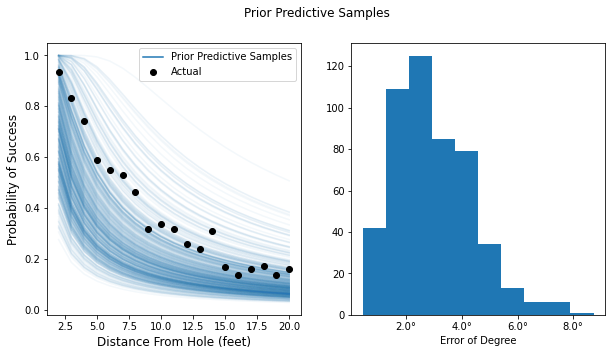

In [ ]:
#@title
from matplotlib.ticker import StrMethodFormatter

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Prior Predictive Samples')

axs[0].plot(df.x, priors.prior.p.values.reshape(-1, len(df)).T, color='C0', alpha=.05)
axs[0].plot([], [], label='Prior Predictive Samples', color='C0')

axs[0].scatter(df.x, df.p, color='k', zorder=10, label='Actual')
    
axs[1].hist(priors.prior.σ.values.ravel())

ax = axs[0]
ax.set_ylabel('Probability of Success', fontsize=12)
ax.set_xlabel('Distance From Hole (feet)', fontsize=12)
ax.legend()

axs[1].set_xlabel('Error of Degree')
axs[1].xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}°'))

## Fitting the Model: Obtaining the Posterior

Fitting the model is just as easy as sampling from the priors - just swap `sample_prior_predictive()` with `sample()`.

In [ ]:
with model:
    idata = pm.sample()

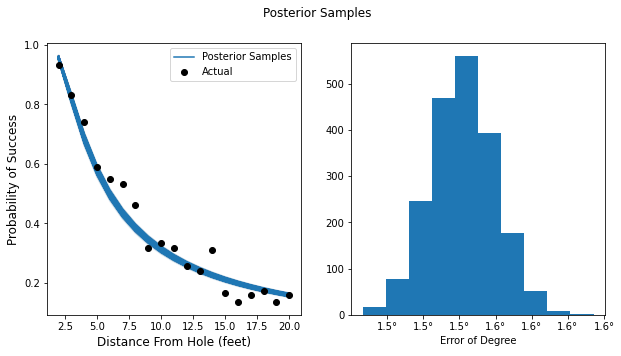

In [ ]:
#@title
from matplotlib.ticker import StrMethodFormatter

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Posterior Samples')

axs[0].plot(df.x, idata.posterior.p.values.reshape(-1, len(df)).T, color='C0', alpha=.05)
axs[0].plot([], [], label='Posterior Samples', color='C0')

axs[0].scatter(df.x, df.p, color='k', zorder=10, label='Actual')
    
axs[1].hist(idata.posterior.σ.values.ravel())

ax = axs[0]
ax.set_ylabel('Probability of Success', fontsize=12)
ax.set_xlabel('Distance From Hole (feet)', fontsize=12)
ax.legend()

axs[1].set_xlabel('Error of Degree')
axs[1].xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}°'))

# Discussion

In conclusion, let's consider what is gained from the first principles model over an off-the-shelf model like logistic regression.

### Model fit

Most importantly, the first principles model fits the data much better than a logistic regression does. We didn't work this out, but for completeness here's the comparison from the Stan case study.

<div align="center">
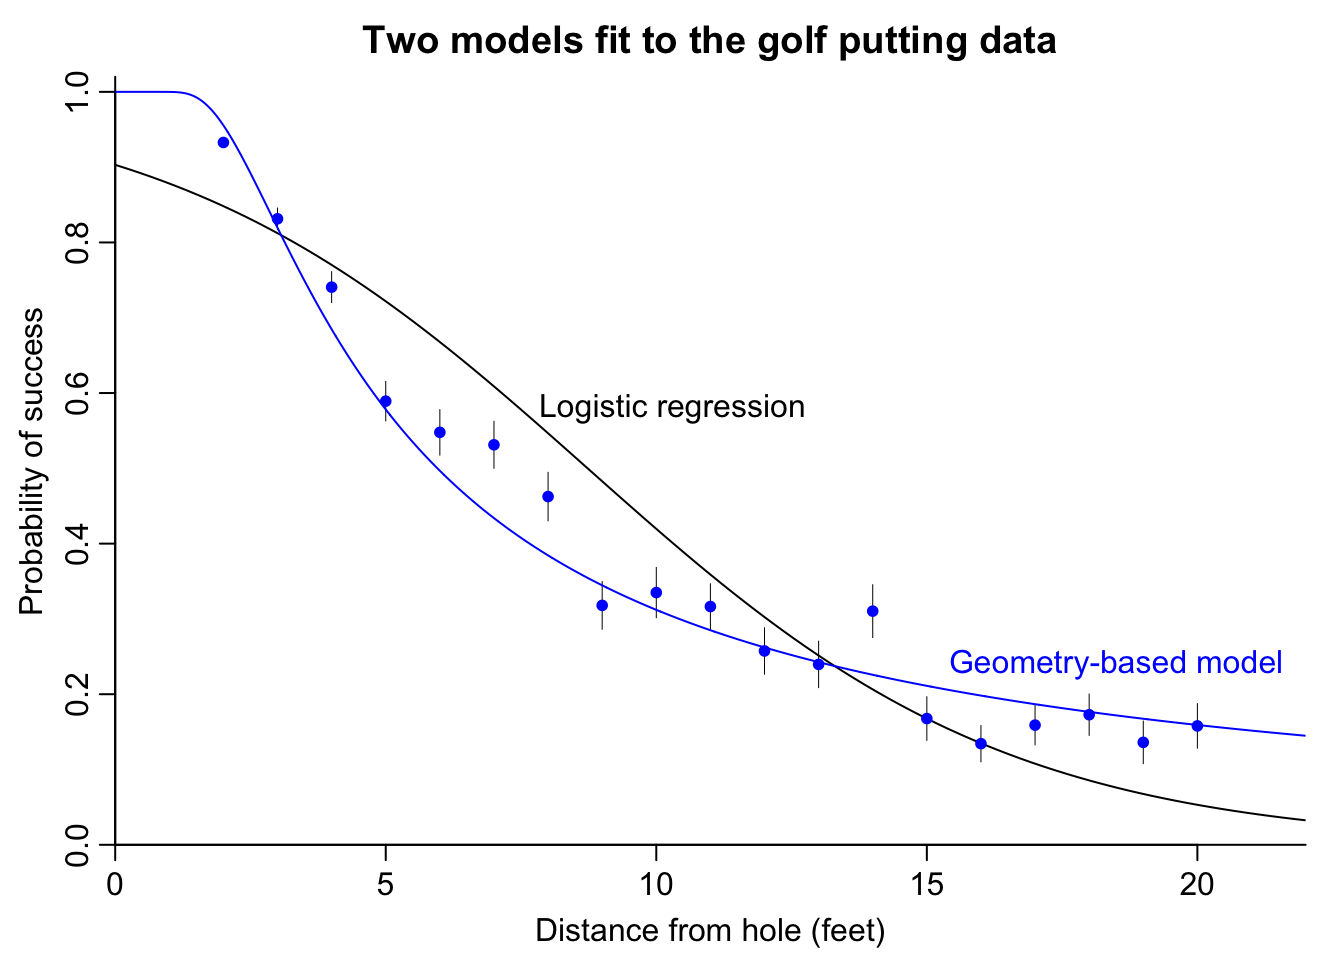
<p>
      Image Source: <a href="https://mc-stan.org/users/documentation/case-studies/golf.html">Stan Development Team</a>
</p>
</div>

### Model transparency

Another benefit from this methodology is that explainability and transparency are built in. For example, one can easily identify assumptions built into the model, not explicitly stated by the authors, with little technical expertise required, e.g.

- Puts are taken on a surface sufficiently flat to be approximated by a plane.

This pays off for more technical challenges as well. For example, the code below demonstrates how much more difficult it is to choose priors for a logistic regression model in the same way that we did above for σ.

In [ ]:
#@markdown ##Input
#@markdown Run this and the hidden cell below to see calculations of $p=\text{invlogit}(a + bx)$
a = None #@param {"type": "number"}
b = None #@param {"type": "number"}

import scipy.special as scipy_special

r = golf_ball_radius = 1.68 / 2  # inches
R = hole_radius = 4.25 / 2       # inches
X = df.x.values

# predictions
y_hat = a + -b * X[:, None]
predictions = scipy_special.expit(y_hat)

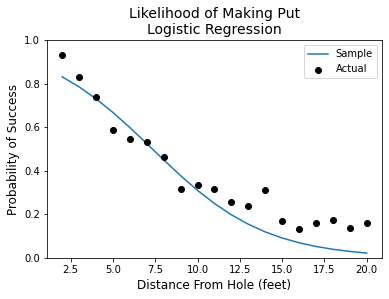

In [ ]:
#@title
fig, ax = plt.subplots()

ax.set_title('Likelihood of Making Put\nLogistic Regression', fontsize=14)

ax.plot(X, predictions, color='C0', label='Sample')

ax.set_ylabel('Probability of Success', fontsize=12)
ax.scatter(df.x, df.p, color='k', zorder=10, label='Actual')
ax.set_xlabel('Distance From Hole (feet)', fontsize=12)
ax.set_ylim([0, 1])
_ = ax.legend()


### More with less

Lastly, one of the advantages I personally find most interesting is the ability to get more with less.

For example, after fitting the first principles model the Stan case study goes on to show how this model fails on a larger data set including puts up to 75 feet. While this new data set has more observations, it still has only a single feature: $x$.

Imagine if we approached this problem with a logistic regression. Without new features there would be nowhere to go. Gelman, however, shows that revising the assumptions of the first principles model to include a term representing how hard the ball is hit yields a still imperfect but much better model.

In other words, the ability to improve a model, by adding information to the model itself without adding information to the data set, opens a whole extra dimension to work with and pull value from.

# Let's Connect

We would love to continue this conversation with you on [discourse](https://discourse.pymc.io/t/pymcon-web-series-the-power-of-bayes-in-industry-your-business-model-is-your-data-generating-process/11264).

- What is your favorite example of a DGP / first principles model?
- Have you applied the ideas in this post in industry?
- What are some of the benefits we missed?

# About the Author

[Dante Gates](https://dantegates.github.io/) is a data scientist in Philadelphia. He currently works for Perpay, using machine learning and statistical methods to help underserved consumers build credit. If that sounds interesting to you, [we're hiring](https://perpay.com/careers)!

# Watermark

In [ ]:
!pip install watermark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.4 MB/s eta 0:00:00


In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aeppl,xarray_einstats

Last updated: Wed Jan 25 2023

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.9.0

aeppl          : 0.0.33
xarray_einstats: 0.4.0

matplotlib: 3.2.2
pandas    : 1.3.5
scipy     : 1.7.3
pymc      : 4.1.4
aesara    : 2.7.9
numpy     : 1.21.6

Watermark: 2.3.1

